In [ ]:
# Importing the required libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nameparser import HumanName
sns.set()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,f1_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importng the data in python environment.
train = pd.read_csv('train.csv')
train_df = train.copy()
test = pd.read_csv('test.csv')
test_df = test.copy()

In [3]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
test_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [5]:
print('Shape of train dataset = ',train_df.shape)
print('shape of test dataset = ',test_df.shape)

Shape of train dataset =  (891, 12)
shape of test dataset =  (418, 11)


The test dataset is only for prediction , we will have our analysis on train dataset only. Any changes made to train datasets would follow same changes in test data too.

### Data Preprocessing

In [6]:
train_df['PassengerId'].nunique() == len(train_df)

True

From above, we can conclude PassengerId is just unique integer values for every record. As such, we can drop them for analysis.

In [7]:
train_df.drop('PassengerId',axis=1,inplace=True)
test_df.drop('PassengerId',axis=1,inplace=True)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


- There are missing values in 3 features in train data.
-  There are missing values in 2 features in test data.

Let's see percentage of missing values -

#### For train data -

In [10]:
missing_cols_train = [x for x in train_df if train_df[x].isnull().any()]
missing_values_sum = train_df[missing_cols_train].isnull().sum()
missing_per_train =  missing_values_sum / len(train_df) * 100
pd.DataFrame({'# Missing values':missing_values_sum,'% Missing':np.round(missing_per_train,2)})

,# Missing values,% Missing
Age,177,19.87
Cabin,687,77.10
Embarked,2,0.22


- Age has nearly 20% of missing values. We can impute the missing values with appropriate method.
- Cabin has more than **77%** of missing values. Imputing these much values will make the data biased. The right approach would be to **drop** Cabin column.
- Embarked has just 2 missing values which can be imputed with mode of similar records.

#### For test data -

In [11]:
missing_cols_test = [x for x in test_df if test_df[x].isnull().any()]
missing_values_sum = test_df[missing_cols_test].isnull().sum()
missing_per_test =  missing_values_sum / len(test_df) * 100
pd.DataFrame({'# Missing values':missing_values_sum,'% Missing':np.round(missing_per_test,2)})

,# Missing values,% Missing
Age,86,20.57
Fare,1,0.24
Cabin,327,78.23


- It would make sense to impute the missing values of test data using logic from train data.

#### Missing Value Treatment

1. Embarked in train data

In [12]:
np.where(train_df['Embarked'].isnull())

(array([ 61, 829], dtype=int64),)

In [13]:
train_df.iloc[[61,829],:]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Since we have only 2 missing values and both are for survived ones having first class tickets, we can impute missing values with most frequent place for matching enteris.

In [14]:
train_df.query('Survived==1 & Pclass==1 & Sex=="female" & SibSp==0 & Parch==0')['Embarked'].value_counts()

C    17
S    14
Name: Embarked, dtype: int64

In [15]:
# Manually imputing the missing values.
train_df.iloc[61,-1] = 'C'
train_df.iloc[829,-1] = 'C'

2. **Age** in train and test data.

Let's have a look at distribution of Ages -

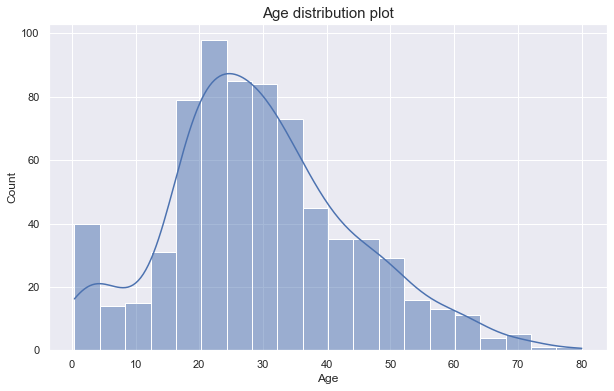

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(x='Age',data=train,kde=True)
plt.title('Age distribution plot', fontsize=15)
plt.show()

In [17]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

From the above analysis,
- the distribution is slightly skewd.
- there is significant variation 
- imputing with mean or mode won't be an appropriate idea.
- it would make more sense if we impute with a model from non-missing train data.

In [18]:
# Taking a subset of data free of missing values.
non_missing_train_df = train_df.drop('Cabin',axis=1).dropna()
non_missing_train_df.shape

(714, 10)

In [19]:
non_missing_train_df.corr()['Age']

Survived   -0.077221
Pclass     -0.369226
Age         1.000000
SibSp      -0.308247
Parch      -0.189119
Fare        0.096067
Name: Age, dtype: float64

There isn't any strong correlation with any other variable. Linear model would fail. Let's use a tree-based model.`
We can drop 'Survived' column as it is target variable so that there wouldn't be any bias. We'll also drop Name and Ticket.

In [20]:
non_missing_train_df.drop(['Survived','Name','Ticket'],axis=1,inplace=True)
non_missing_train_df.shape

(714, 7)

In [21]:
# Pre-processing the data for model training.
non_missing_train_df = pd.get_dummies(non_missing_train_df,drop_first=True)
non_missing_train_df.shape

(714, 8)

In [22]:
non_missing_train_df.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,3,26.0,0,0,7.9250,0,0,1


In [23]:
x = non_missing_train_df.drop('Age',axis=1)
y = non_missing_train_df['Age']
age_predictor = RandomForestRegressor()
age_predictor.fit(x,y)

RandomForestRegressor()

In [24]:
age_predictor.score(x,y)

0.6928506554131276

We have about 70% information for prediction. We can use this model to predict missing age values in train and test data.

In [25]:
missing_age_train_df = train_df[train_df['Age'].isnull()] 
missing_age_train_df.shape

(177, 11)

In [26]:
# Reshaping the missing_age_train df so that model can predict on these records.
missing_age_train_df.drop(['Survived','Age','Cabin','Name','Ticket'],axis=1,inplace=True)
missing_age_train_df = pd.get_dummies(missing_age_train_df, drop_first=True)
missing_age_train_df.head(3)

,Pclass,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
5,3,0,0,8.4583,1,1,0
17,2,0,0,13.0000,1,0,1
19,3,0,0,7.2250,0,0,0


In [27]:
missing_age_index_train_df = missing_age_train_df.index
missing_age_index_train_df

Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
           dtype='int64', length=177)

In [28]:
# Looping through each index to populate the missing values of Age in train_df (master) data.
for index in missing_age_index_train_df:
    model_input = np.array(missing_age_train_df.loc[index].values).reshape(1,7)
    train_df.loc[index,'Age'] = np.round(age_predictor.predict(model_input),1)
print('Successfuly Imputed !')  

Successfuly Imputed !


In [29]:
# Reshaping the test data to impute missing values using the same model.
missing_age_test_df = test_df[test['Age'].isnull()]
missing_age_test_df.drop(['Name','Age','Cabin','Ticket'],axis=1,inplace=True)
missing_age_test_df = pd.get_dummies(missing_age_test_df,drop_first=True)
missing_age_test_df.head(3)

,Pclass,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
10,3,0,0,7.8958,1,0,1
22,1,0,0,31.6833,0,0,1
29,3,2,0,21.6792,1,0,0


In [30]:
missing_age_index_test_df = missing_age_test_df.index
missing_age_index_test_df

Int64Index([ 10,  22,  29,  33,  36,  39,  41,  47,  54,  58,  65,  76,  83,
             84,  85,  88,  91,  93, 102, 107, 108, 111, 116, 121, 124, 127,
            132, 133, 146, 148, 151, 160, 163, 168, 170, 173, 183, 188, 191,
            199, 200, 205, 211, 216, 219, 225, 227, 233, 243, 244, 249, 255,
            256, 265, 266, 267, 268, 271, 273, 274, 282, 286, 288, 289, 290,
            292, 297, 301, 304, 312, 332, 339, 342, 344, 357, 358, 365, 366,
            380, 382, 384, 408, 410, 413, 416, 417],
           dtype='int64')

In [31]:
# Looping through each index to populate the missing values of Age in test_df (master) data.
for index in missing_age_index_test_df:
    model_input = np.array(missing_age_test_df.loc[index].values).reshape(1,7)
    test_df.loc[index,'Age'] = np.round(age_predictor.predict(model_input),1)
print('Successfuly Imputed !')  

Successfuly Imputed !


In [32]:
# Verifying the same.
train_df['Age'].isnull().sum(), test_df['Age'].isnull().sum()

(0, 0)

3. **Fare** in test data .

In [33]:
np.where(test['Fare'].isnull())

(array([152], dtype=int64),)

In [34]:
test_df.loc[152]

Pclass                       3
Name        Storey, Mr. Thomas
Sex                       male
Age                       60.5
SibSp                        0
Parch                        0
Ticket                    3701
Fare                       NaN
Cabin                      NaN
Embarked                     S
Name: 152, dtype: object

For Fare, we have just one missing value, we can impute it with Fare of ones matching features from **train_df**.

In [35]:
train_df.query('Pclass == 3 & Age > 60 & SibSp == 0 & Parch == 0 & Embarked == "S" & Sex=="male" ')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
326,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S
851,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S


We have found 2 matching records, let's just impute it with mean of both fares.

In [36]:
np.mean([6.2375,7.7750])

7.00625

In [37]:
test_df.loc[152,'Fare'] = 7.00625

In [38]:
# Verifying the same.
test_df['Fare'].isnull().sum()

0

4. **Cabin** in train and test data.

In [39]:
train_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Looking at values, we can notice a pattern. The alphabet in each value corresponds to specific deck.
- We can extract deck for known ones.
- For missing ones, we can replace it with "U" for unknown.

In [40]:
def find_deck(cabin):
    try :
        return cabin[0]
    except :
        return 'U'

In [41]:
train_df['Deck'] = train_df['Cabin'].apply(find_deck)
test_df['Deck'] = test_df['Cabin'].apply(find_deck)

In [42]:
train_df['Deck'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [43]:
test_df['Deck'].unique()

array(['U', 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

Now we can drop **Cabin** from both datasets.

In [44]:
train_df.drop('Cabin',axis=1,inplace=True)
test_df.drop('Cabin',axis=1,inplace=True)

In [45]:
train_df.isnull().sum().sum(),test_df.isnull().sum().sum()

(0, 0)

Now, we have no missing values. We can proceed to EDA.

We will have all our analysis on train data only.

### Exploratory Data Analysis

In [46]:
train_df.shape

(891, 11)

In [47]:
train_df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,U
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C


In [48]:
pd.DataFrame(train_df.dtypes.value_counts(),columns=['# of variables'])

,# of variables
object,5
int64,4
float64,2


-  There are 5 variables having string values, 4 having integer values and 2 having float values. 

#### Traget Variable Analysis

In [49]:
train_df['Survived'].unique()

array([0, 1], dtype=int64)

- The target variable has 2 discrete outcomes making the problem a binary classification.

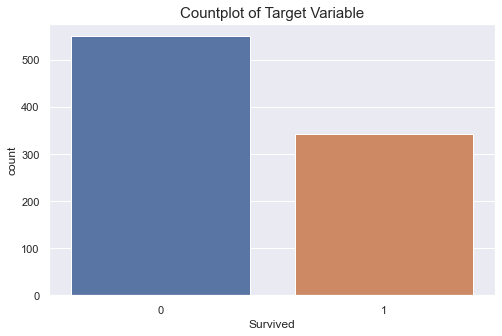

In [50]:
plt.figure(figsize=(8,5))
sns.countplot(x='Survived',data=train_df)
plt.title('Countplot of Target Variable', fontsize=15)
plt.show()

In [51]:
train_df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

- The data is unbalanced, there are nearly 61% of records where passengers didn't survive and 38% of ones who survived.
- Probability of being survived is less.

#### Features Analysis

In [52]:
train_df.drop('Survived',axis=1).shape[1]

10

 - We have 10 independent variables meant to predict the target variable. 

Let's analyze each feature one by one.

#### 1. Pclass

In [53]:
train_df['Pclass'].unique()

array([3, 1, 2], dtype=int64)

- The Pclass represent the ticket class and there are 3 classes. 
- The datatype is categorical and level of measurement is ordinal.

In [54]:
train_df['Pclass'].value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

- More than half of passengers opted for third class, however there were few people in 2nd class compared to 1st class.

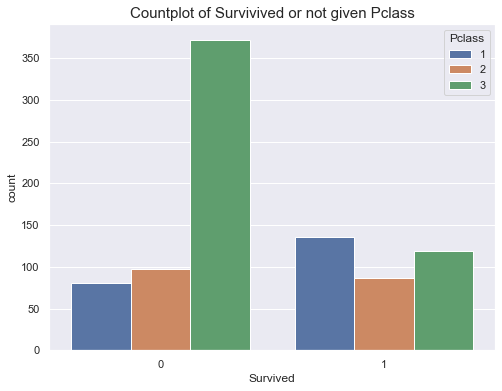

In [55]:
plt.figure(figsize=(8,6))
sns.countplot(x='Survived',hue='Pclass', data=train_df)
plt.title('Countplot of Survivived or not given Pclass', fontsize=15)
plt.show()

The above plot indicates :
- Pclass is indicating the chance of survival.
- The people from 3rd class has very low probability of survival.
- The people from 1st class has high probability of survival

#### 2. Name

In [56]:
train_df['Name'][:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- This is just name for every passenger, and all of which are unique .
- A very interesting information can be deduced from title of name.

#### 3. Sex

In [57]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

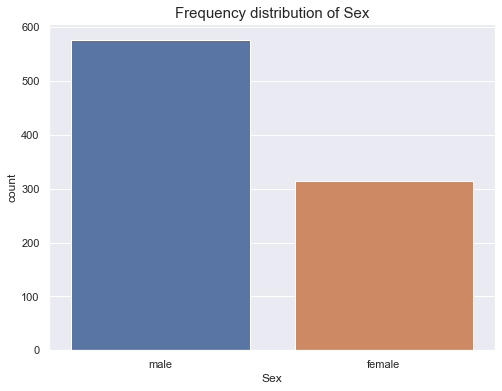

In [58]:
plt.figure(figsize=(8,6))
sns.countplot(x='Sex',data=train_df)
plt.title('Frequency distribution of Sex', fontsize=15)
plt.show()

- There are more number of males as compared to females.
- The data type is categorical and level of measurement is nominal.

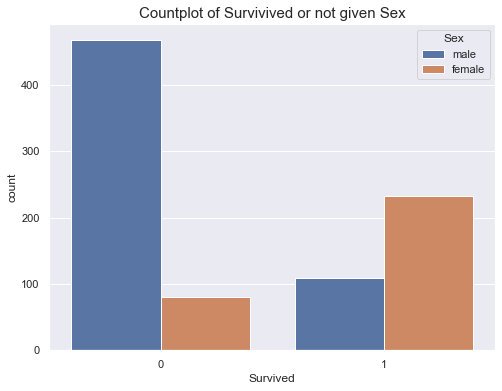

In [59]:
plt.figure(figsize=(8,6))
sns.countplot(x='Survived',hue='Sex', data=train_df)
plt.title('Countplot of Survivived or not given Sex', fontsize=15)
plt.show()

- The males have high probability of being not survived.
- The females have more chance of survival.

#### 4. Age

In [60]:
train_df['Age'].describe()

count    891.000000
mean      29.520281
std       13.744156
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

- The age is quantative continous variable.
- There were people of all ages , from infant to old ones.
- The mean is slightly greater than median indicating skewness.

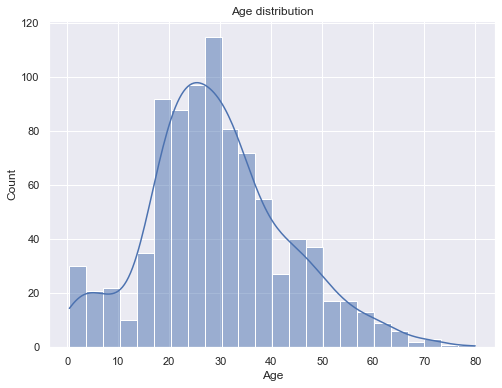

In [61]:
plt.figure(figsize=(8,6))
sns.histplot(x='Age',kde=True,data=train_df)
plt.title('Age distribution')
plt.show()

- The distribution seems same as it was before imputing missing values. 
- The plot indicates outliers.

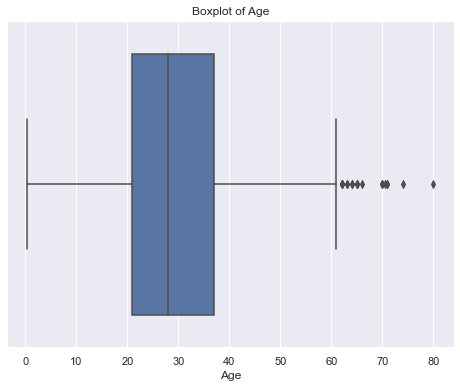

In [62]:
# Outlier Analysis
plt.figure(figsize=(8,6))
sns.boxplot(train_df['Age'])
plt.title('Boxplot of Age')
plt.show()

In [63]:
train_df.query('Age > 61')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
33,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,S,U
54,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,C,B
96,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,C,A
116,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,Q,U
252,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,S,C
275,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0,1,0,13502,77.9583,S,D
280,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,Q,U
438,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,S,C
456,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,S,E
483,1,3,"Turkula, Mrs. (Hedwig)",female,63.0,0,0,4134,9.5875,S,U


- Though, they seems outliers for the given amount of data, but they are not errors. 
- It is quite possible to have ages above 60 for passengers. 
- We won't substitute or drop them, instead we'll use models which are less sensitive to outliers.

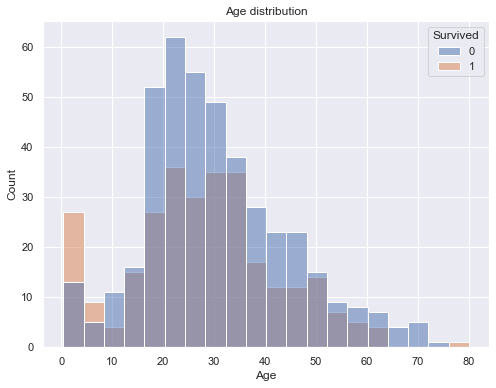

In [64]:
plt.figure(figsize=(8,6))
sns.histplot(x='Age',hue='Survived',data=train)
plt.title('Age distribution')
plt.show()

<Figure size 864x576 with 0 Axes>

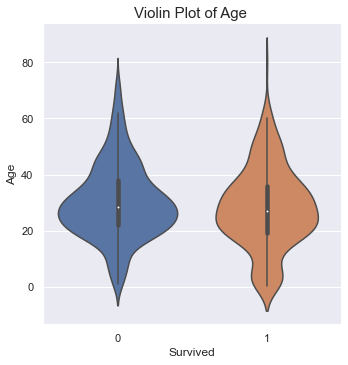

In [65]:
plt.figure(figsize=(12,8))
sns.catplot(x='Survived',y='Age',data=train_df,kind='violin')
plt.title('Violin Plot of Age ', fontsize=15)
plt.show()

In [66]:
train.groupby('Survived')['Age'].describe().T

Survived,0,1
count,424.000000,290.000000
mean,30.626179,28.343690
std,14.172110,14.950952
min,1.000000,0.420000
25%,21.000000,19.000000
50%,28.000000,28.000000
75%,39.000000,36.000000
max,74.000000,80.000000


- For extreme ages ,there is high probability of survival.
- We can see the median of both survived and non-survived are same.
- Age in particular doesn't indicate chances of survival.

#### 5. SibSp

In [67]:
train_df['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

- This represents numbers of siblings/spouses aboard the Titanic.
- The data type is discrete numerical.

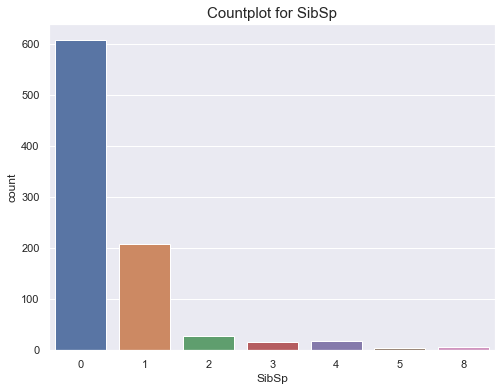

In [68]:
plt.figure(figsize=(8,6))
sns.countplot(x='SibSp',data=train_df)
plt.title('Countplot for SibSp', fontsize=15)
plt.show()

In [69]:
train_df['SibSp'].value_counts(normalize=True)

0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: SibSp, dtype: float64

- Majority of passenger onboard had no siblings or unmarried ones.

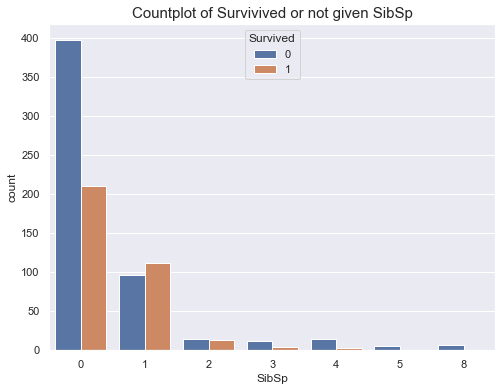

In [70]:
plt.figure(figsize=(8,6))
sns.countplot(hue='Survived',x='SibSp', data=train_df)
plt.title('Countplot of Survivived or not given SibSp', fontsize=15)
plt.show()

- The passengers having no siblings/spouse onboard has high probabilty of being not survived.

#### 6. Parch

In [71]:
train_df['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

- This feature deals with number of parents / children aboard the Titanic.
- The data type is discrete numerical.

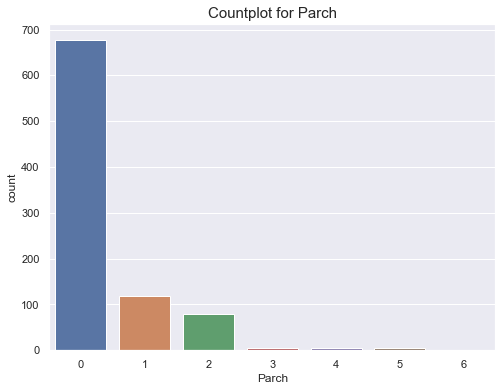

In [72]:
plt.figure(figsize=(8,6))
sns.countplot(x='Parch',data=train_df)
plt.title('Countplot for Parch', fontsize=15)
plt.show()

- Similar to SibSp, there were high number of people travelling without parent or children.

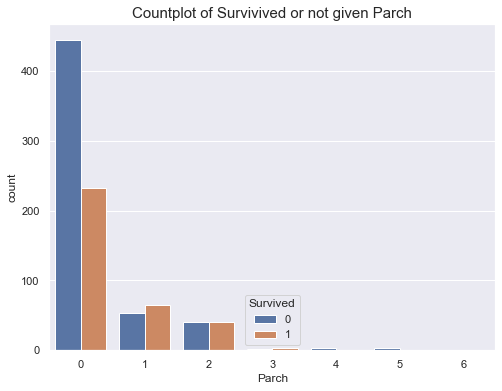

In [73]:
plt.figure(figsize=(8,6))
sns.countplot(hue='Survived',x='Parch', data=train_df)
plt.title('Countplot of Survivived or not given Parch', fontsize=15)
plt.show()

- Similar to SibSp, there were high probability of being not survived given Parch = 0. 
- We can have a new variable whether a person is alone or not that could help in model building.
- Combining SibSp and Parch , we can contruct a new feature representing total number of relatives.

#### 7. Ticket

In [74]:
train_df['Ticket'][:5]

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [75]:
train_df['Ticket'].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

- It is just the the ticket number .
- It is very difficult to draw patterns from it.
- There are 681 unique values of out of 891 and data type is categorical and level of measurement is nominal. Having these much nominal variables would be a lot tricky for a model to learn.
- We already have pclass and fare which could potentially cover exclusion of ticket feature.
- We'll drop Ticket from our datasets.

In [76]:
train_df.drop('Ticket',axis=1,inplace=True)
test_df.drop('Ticket',axis=1,inplace=True)

#### 8. Fare

In [77]:
train_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

- The fare is continuous variable ranging from 0 to 512 with a huge standard deviation.

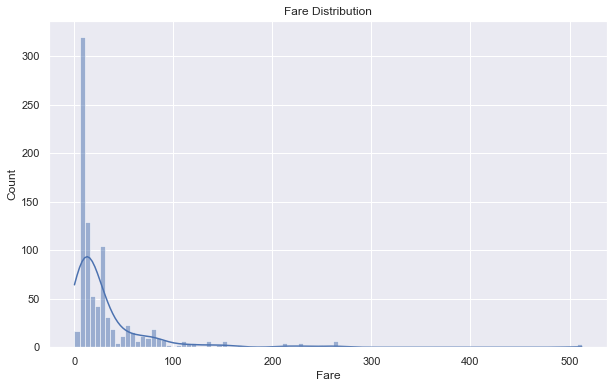

In [78]:
plt.figure(figsize=(10,6))
sns.histplot(x='Fare', data=train, kde=True,bins=100)
plt.title('Fare Distribution')
plt.show()

- There is huge skewness and it surely doesn't resemble a normal distribution.

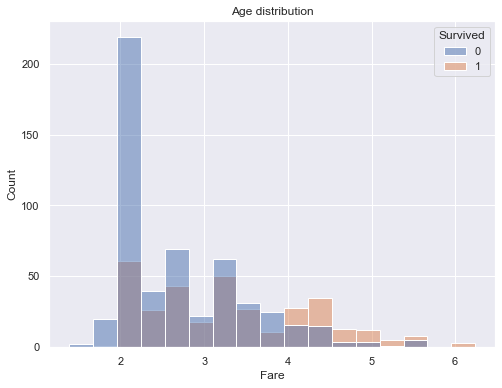

In [79]:
plt.figure(figsize=(8,6))
sns.histplot(x=np.log(train['Fare']),hue='Survived',data=train)
plt.title('Age distribution')
plt.show()

- Taking the log transformation for easier interpretibilty , it is quite clear high fares have high chances of survival.
- It would be more appropriate if we bin the fares for model training.

#### 9. Embarked

In [80]:
train_df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

- The embarked represents the port of Embarkation. 
- The data type is categorical and level of measurement is nominal.

In [81]:
train_df['Embarked'].value_counts(normalize=True)

S    0.722783
C    0.190797
Q    0.086420
Name: Embarked, dtype: float64

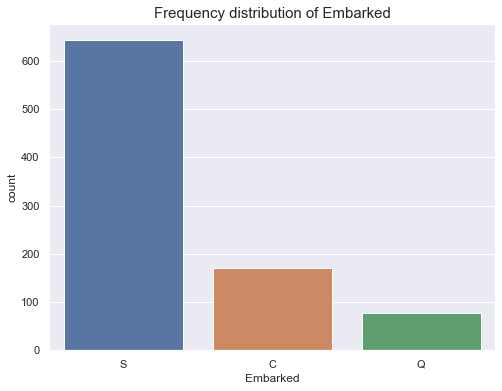

In [82]:
plt.figure(figsize=(8,6))
sns.countplot(x='Embarked',data=train_df)
plt.title('Frequency distribution of Embarked', fontsize=15)
plt.show()

- Most of the passengers, nearly 72% embarked from Southampton.

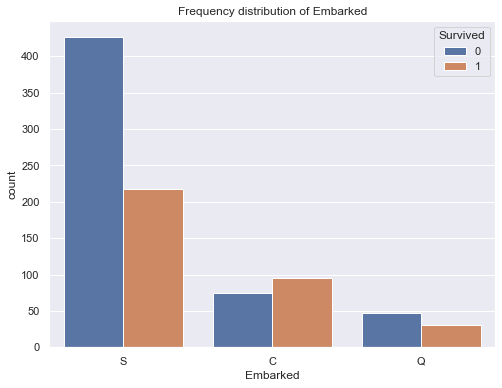

In [83]:
plt.figure(figsize=(8,6))
sns.countplot(x='Embarked',hue='Survived',data=train_df)
plt.title('Frequency distribution of Embarked')
plt.show()

- Southampton passengers has high probability of being not survived. 
- **But** that can't be said for certain as majority of passengers from here.

#### 10. Deck

In [84]:
train_df['Deck'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [85]:
test_df['Deck'].unique()

array(['U', 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

- All the unique values of deck from test data is present in our train data.
- The data type is categorical and ordinal in nature.


In [86]:
train_df['Deck'].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Deck, dtype: int64

In [87]:
train_df.groupby(['Survived','Deck'])['Survived'].count()

Survived  Deck
0         A         8
          B        12
          C        24
          D         8
          E         8
          F         5
          G         2
          T         1
          U       481
1         A         7
          B        35
          C        35
          D        25
          E        24
          F         8
          G         2
          U       206
Name: Survived, dtype: int64

- From above, passengers having decks B,C,D and E have high chance for survival.
- But for most of data the deck is unknown.
- We can create a new feature indicating whether deck is known or not.

#### Sex + Age + Survived

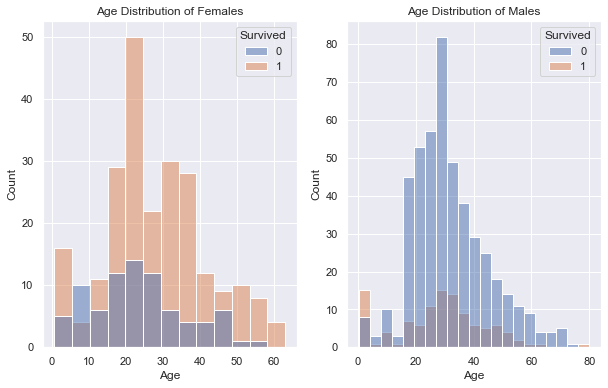

In [88]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.histplot(x='Age',hue='Survived',data=train_df[train_df['Sex']=='female'])
plt.title('Age Distribution of Females')
plt.subplot(1,2,2)
sns.histplot(x='Age',hue='Survived',data=train_df[train_df['Sex']=='male'])
plt.title('Age Distribution of Males')
plt.show()

- The data shows females have higher chances of survival.
- The elderly and infants had higher chances of survival irrespective of sex.
- As for middle age group , it isn't certain.
- This insight also suggests making categorical features from age.

#### Fare + Sex + Survived

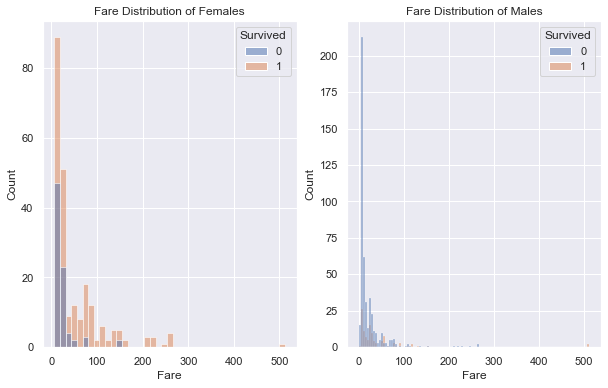

In [89]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.histplot(x='Fare',hue='Survived',data=train_df[train_df['Sex']=='female'])
plt.title('Fare Distribution of Females')
plt.subplot(1,2,2)
sns.histplot(x='Fare',hue='Survived',data=train_df[train_df['Sex']=='male'])
plt.title('Fare Distribution of Males')
plt.show()

- There seems to be not any significant insight from this analysis.
- It only suggests females have high chance of survival for any fare.

#### Fare + Pclass + Survived

In [90]:
train_df.groupby(['Survived','Pclass'])['Fare'].median()

Survived  Pclass
0         1         44.7500
          2         13.0000
          3          8.0500
1         1         77.9583
          2         21.0000
          3          8.5167
Name: Fare, dtype: float64

<Figure size 720x576 with 0 Axes>

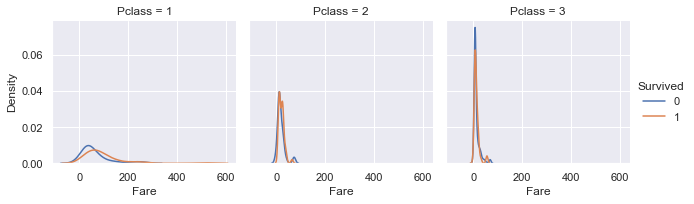

In [91]:
plt.figure(figsize=(10,8))
g = sns.FacetGrid(train_df,col='Pclass',hue='Survived').map(sns.kdeplot,'Fare')
g.add_legend()
plt.show()

- The above analysis confirms if the ticket price was high , there were strong chances of survival.

#### Parch + SibSp + Survived

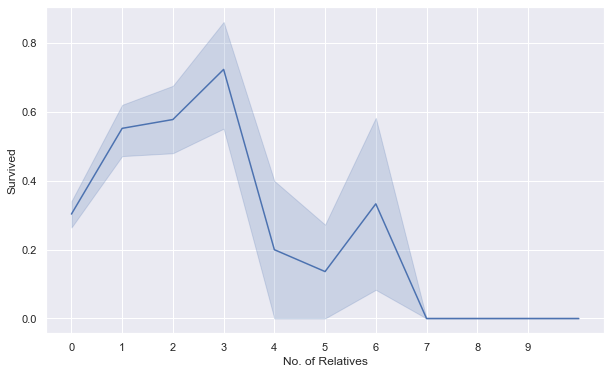

In [92]:
plt.figure(figsize=(10,6))
total_relatives = train_df['Parch'] + train_df['SibSp']
sns.lineplot(x=total_relatives,y=train_df['Survived'])
plt.xlabel('No. of Relatives')
plt.xticks(np.arange(0,10,1))
plt.show()

- Above plot shows having upto 3 members of family have high chances of survival.
- Total relatives seems to good feature comprising both *SibSp and Parch*.
- We can drop both columns and can have one representing both.

#### Correlation Matrix

<AxesSubplot:>

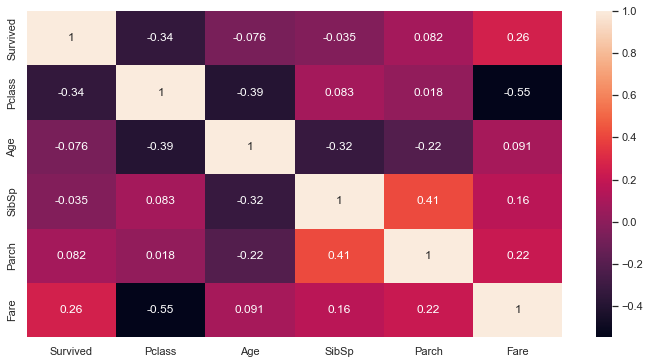

In [93]:
plt.figure(figsize=(12,6))
sns.heatmap(train_df.corr(),annot=True)

- There isn't any strong correlation .
- Parch and Sibsp seems to be slightly correlated , another hint to have a feature union of these two.

**EDA Summary**
- Females have high chances of survival.
- From Name, titles can be extracted.
- Infants and elderly people have high chance of survival.
- It is clear for certain ages and alongwith sex variable,age could determine survival.
- If a person is alone, he has higher chances of not surviving.
- We may create a feature indicating whether passenger is alone or not.
- Fares are not normally distributed and  we may need to bins the fare.
- Sum of SibSp and Parch seems to be more apt for model training as both convey same information.
- Ticket has been dropped, as it is very difficult to deduce any type of pattern.
- 72% of passengers have boarded the ship on same location, commenting on location based analysis wouldn't be appropriate.
- Deck extraction from Cabin could be a potential feature.
- We can create a new feature indicating whether deck is known or not.
- Tree based model would be most appropriate for given datasets.

### Feature Engineering

#### 1. Creating dummy variable for Sex and Embarked.

In [94]:
sex_dummy = pd.get_dummies(train_df['Sex'],drop_first=True)
embarked_dummy = pd.get_dummies(train_df['Embarked'],drop_first=True)
features = pd.concat([train_df,sex_dummy,embarked_dummy],axis=1).drop(['Sex','Embarked','Survived'],axis=1)
features.head()

,Pclass,Name,Age,SibSp,Parch,Fare,Deck,male,Q,S
0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,U,1,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,C,0,0,0
2,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,U,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,C,0,0,1
4,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,U,1,0,1


#### 2. Combining SibSp and Parch.

In [95]:
features['total_relatives'] = features['SibSp'] + features['Parch']
features.drop(['SibSp','Parch'],axis=1,inplace=True)
features.head()

,Pclass,Name,Age,Fare,Deck,male,Q,S,total_relatives
0,3,"Braund, Mr. Owen Harris",22.0,7.2500,U,1,0,1,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,71.2833,C,0,0,0,1
2,3,"Heikkinen, Miss. Laina",26.0,7.9250,U,0,0,1,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,53.1000,C,0,0,1,1
4,3,"Allen, Mr. William Henry",35.0,8.0500,U,1,0,1,0


#### 3. Creating a new feature indicating whether passenger is alone or not

In [96]:
features['is_alone'] = features['total_relatives'].map(lambda x: 'not_alone' if(x>0) else 'alone')
is_alone_dummy = pd.get_dummies(features['is_alone'],drop_first=True)
features= pd.concat([features,is_alone_dummy],axis=1).drop('is_alone',axis=1)
features.head()

,Pclass,Name,Age,Fare,Deck,male,Q,S,total_relatives,not_alone
0,3,"Braund, Mr. Owen Harris",22.0,7.2500,U,1,0,1,1,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,71.2833,C,0,0,0,1,1
2,3,"Heikkinen, Miss. Laina",26.0,7.9250,U,0,0,1,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,53.1000,C,0,0,1,1,1
4,3,"Allen, Mr. William Henry",35.0,8.0500,U,1,0,1,0,0


#### 4. Creating a new feature representing age category.

In [97]:
age_bins =[0,18,22,25,30,35,45,55,80]

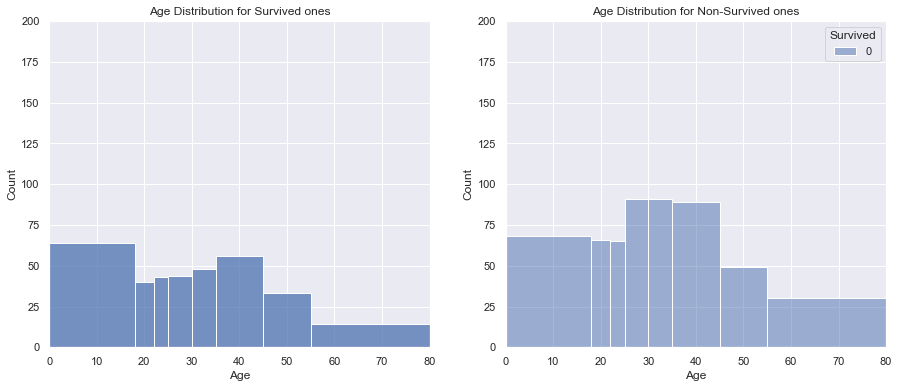

In [98]:
survived = train_df[train_df['Survived']==1]
non_survived = train_df[train_df['Survived']==0]

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.histplot(x='Age',bins=age_bins,data=survived)
plt.title('Age Distribution for Survived ones')
plt.xlim(0,80)
plt.ylim(0,200)
plt.subplot(1,2,2)
sns.histplot(x='Age',bins=age_bins,hue='Survived',data=non_survived)
plt.title('Age Distribution for Non-Survived ones')
plt.xlim(0,80)
plt.ylim(0,200)
plt.show()

- 8 bins seems to be reasonable choice for binning.

In [99]:
train_df['age_bins'] = pd.cut(features['Age'],bins=age_bins,include_lowest=True)
train_df.groupby(['age_bins','Survived',])['Survived'].count()

age_bins        Survived
(-0.001, 18.0]  0           85
                1           73
(18.0, 22.0]    0           66
                1           43
(22.0, 25.0]    0           65
                1           37
(25.0, 30.0]    0           93
                1           48
(30.0, 35.0]    0           81
                1           49
(35.0, 45.0]    0           87
                1           50
(45.0, 55.0]    0           43
                1           29
(55.0, 80.0]    0           29
                1           13
Name: Survived, dtype: int64

In [100]:
features['age_bins'] = train_df['age_bins']
features.head(3)

,Pclass,Name,Age,Fare,Deck,male,Q,S,total_relatives,not_alone,age_bins
0,3,"Braund, Mr. Owen Harris",22.0,7.2500,U,1,0,1,1,1,"(18.0, 22.0]"
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,71.2833,C,0,0,0,1,1,"(35.0, 45.0]"
2,3,"Heikkinen, Miss. Laina",26.0,7.9250,U,0,0,1,0,0,"(25.0, 30.0]"


In [101]:
age_encoder = OrdinalEncoder(dtype=np.int64)
age_encoder.fit(features[['age_bins']])

OrdinalEncoder(dtype=<class 'numpy.int64'>)

In [102]:
age_encoder.categories_

[array([Interval(-0.001, 18.0, closed='right'),
        Interval(18.0, 22.0, closed='right'),
        Interval(22.0, 25.0, closed='right'),
        Interval(25.0, 30.0, closed='right'),
        Interval(30.0, 35.0, closed='right'),
        Interval(35.0, 45.0, closed='right'),
        Interval(45.0, 55.0, closed='right'),
        Interval(55.0, 80.0, closed='right')], dtype=object)]

In [103]:
features['age_bins'] = age_encoder.transform(features[['age_bins']])
features.head()

,Pclass,Name,Age,Fare,Deck,male,Q,S,total_relatives,not_alone,age_bins
0,3,"Braund, Mr. Owen Harris",22.0,7.2500,U,1,0,1,1,1,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,71.2833,C,0,0,0,1,1,5
2,3,"Heikkinen, Miss. Laina",26.0,7.9250,U,0,0,1,0,0,3
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,53.1000,C,0,0,1,1,1,4
4,3,"Allen, Mr. William Henry",35.0,8.0500,U,1,0,1,0,0,4


#### 5. Creating  new feature from title present in Name.

In [104]:
# Extracting title from Name.
def find_title(name):
    # Using HumanName module.
    dict_name = HumanName(name).as_dict()
    return dict_name['title']

In [105]:
features['title'] = features['Name'].apply(find_title)
features.head(3)

,Pclass,Name,Age,Fare,Deck,male,Q,S,total_relatives,not_alone,age_bins,title
0,3,"Braund, Mr. Owen Harris",22.0,7.2500,U,1,0,1,1,1,1,Mr.
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,71.2833,C,0,0,0,1,1,5,Mrs.
2,3,"Heikkinen, Miss. Laina",26.0,7.9250,U,0,0,1,0,0,3,Miss.


In [106]:
features['title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', '', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'the Countess. of'], dtype=object)

For some records, the function wasn't able to extract. Let's examine it manually -

In [107]:
features.loc[features['title'] == ""]

,Pclass,Name,Age,Fare,Deck,male,Q,S,total_relatives,not_alone,age_bins,title
30,1,"Uruchurtu, Don. Manuel E",40.0,27.7208,U,1,0,0,0,0,5,
449,1,"Peuchen, Major. Arthur Godfrey",52.0,30.5000,C,1,0,1,0,0,6,
536,1,"Butt, Major. Archibald Willingham",45.0,26.5500,B,1,0,1,0,0,5,
822,1,"Reuchlin, Jonkheer. John George",38.0,0.0000,U,1,0,1,0,0,5,


For 4 of these, we can manually update the title.

In [108]:
features.iloc[30,-1] = 'Don'
features.iloc[449,-1] = 'Major'
features.iloc[536,-1] = 'Major'
features.iloc[822,-1] = 'Mr.'

In [109]:
features['title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'the Countess. of'], dtype=object)

We can encode the title based on title similarities.

In [110]:
def title_encoding(title):
    if title == 'Master.': 
        return 'boys'
    elif title in ['Miss.', 'Ms.','Lady.' ]:
        return 'girls'
    elif title == 'Mr.':
        return 'men'
    elif title in ['Mrs.','Mme.']:
        return 'women'
    else:
        return 'vip'

In [111]:
features['title'] = features['title'].apply(title_encoding)
features.head(3)

,Pclass,Name,Age,Fare,Deck,male,Q,S,total_relatives,not_alone,age_bins,title
0,3,"Braund, Mr. Owen Harris",22.0,7.2500,U,1,0,1,1,1,1,men
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,71.2833,C,0,0,0,1,1,5,women
2,3,"Heikkinen, Miss. Laina",26.0,7.9250,U,0,0,1,0,0,3,girls


In [112]:
# Getting dummies for title variable as it is on nominal scale.
title_dummy = pd.get_dummies(features['title'], drop_first=True)
features = pd.concat([features,title_dummy],axis=1).drop('title',axis=1)
features.head()

,Pclass,Name,Age,Fare,Deck,male,Q,S,total_relatives,not_alone,age_bins,girls,men,vip,women
0,3,"Braund, Mr. Owen Harris",22.0,7.2500,U,1,0,1,1,1,1,0,1,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,71.2833,C,0,0,0,1,1,5,0,0,0,1
2,3,"Heikkinen, Miss. Laina",26.0,7.9250,U,0,0,1,0,0,3,1,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,53.1000,C,0,0,1,1,1,4,0,0,0,1
4,3,"Allen, Mr. William Henry",35.0,8.0500,U,1,0,1,0,0,4,0,1,0,0


Now we can drop the name.

In [113]:
features.drop('Name',axis=1,inplace=True)

#### 8. Creating new feature fare per head.

In [114]:
features['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

It would make quite sense to have fare per passenger. It is quite possible that family booked under one ticket.

In [115]:
features['fare_per_head'] = np.round(features['Fare'] / (features['total_relatives']+1),2)
features.head()

,Pclass,Age,Fare,Deck,male,Q,S,total_relatives,not_alone,age_bins,girls,men,vip,women,fare_per_head
0,3,22.0,7.2500,U,1,0,1,1,1,1,0,1,0,0,3.62
1,1,38.0,71.2833,C,0,0,0,1,1,5,0,0,0,1,35.64
2,3,26.0,7.9250,U,0,0,1,0,0,3,1,0,0,0,7.92
3,1,35.0,53.1000,C,0,0,1,1,1,4,0,0,0,1,26.55
4,3,35.0,8.0500,U,1,0,1,0,0,4,0,1,0,0,8.05


#### 9. Creating new feature Fare_level from Fares.

In [116]:
pd.cut(features['Fare'],bins=10,include_lowest=True).value_counts()

(-0.513, 51.233]      732
(51.233, 102.466]     106
(102.466, 153.699]     31
(204.932, 256.165]     11
(256.165, 307.398]      6
(461.096, 512.329]      3
(153.699, 204.932]      2
(307.398, 358.63]       0
(358.63, 409.863]       0
(409.863, 461.096]      0
Name: Fare, dtype: int64

From above, we can see there are lot of people belonging to first interval. Let's create bins of our choice.

In [117]:
fare_bins = [0,5,8,10,20,30,50,100,300,515]
pd.cut(features['Fare'],bins=fare_bins,include_lowest=True).value_counts()

(5.0, 8.0]        224
(10.0, 20.0]      179
(20.0, 30.0]      142
(50.0, 100.0]     107
(8.0, 10.0]        95
(30.0, 50.0]       74
(100.0, 300.0]     50
(-0.001, 5.0]      17
(300.0, 515.0]      3
Name: Fare, dtype: int64

In [118]:
features['fare_level'] =  pd.cut(features['Fare'],bins=fare_bins,include_lowest=True)
fare_encoder = OrdinalEncoder(dtype=np.int64)
fare_encoder.fit(features[['fare_level']])

OrdinalEncoder(dtype=<class 'numpy.int64'>)

In [119]:
fare_encoder.categories_

[array([Interval(-0.001, 5.0, closed='right'),
        Interval(5.0, 8.0, closed='right'),
        Interval(8.0, 10.0, closed='right'),
        Interval(10.0, 20.0, closed='right'),
        Interval(20.0, 30.0, closed='right'),
        Interval(30.0, 50.0, closed='right'),
        Interval(50.0, 100.0, closed='right'),
        Interval(100.0, 300.0, closed='right'),
        Interval(300.0, 515.0, closed='right')], dtype=object)]

In [120]:
features['fare_level'] = fare_encoder.transform(features[['fare_level']])
features.head(3)

,Pclass,Age,Fare,Deck,male,Q,S,total_relatives,not_alone,age_bins,girls,men,vip,women,fare_per_head,fare_level
0,3,22.0,7.2500,U,1,0,1,1,1,1,0,1,0,0,3.62,1
1,1,38.0,71.2833,C,0,0,0,1,1,5,0,0,0,1,35.64,6
2,3,26.0,7.9250,U,0,0,1,0,0,3,1,0,0,0,7.92,1


#### 10. Converting Deck to ordinal measures.


In [121]:
deck_encoder = OrdinalEncoder(dtype=np.int64)
deck_encoder.fit(features[['Deck']])

OrdinalEncoder(dtype=<class 'numpy.int64'>)

In [122]:
deck_encoder.categories_

[array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'], dtype=object)]

In [123]:
features['Deck'] = deck_encoder.transform(features[['Deck']])
features.head(3)

,Pclass,Age,Fare,Deck,male,Q,S,total_relatives,not_alone,age_bins,girls,men,vip,women,fare_per_head,fare_level
0,3,22.0,7.2500,8,1,0,1,1,1,1,0,1,0,0,3.62,1
1,1,38.0,71.2833,2,0,0,0,1,1,5,0,0,0,1,35.64,6
2,3,26.0,7.9250,8,0,0,1,0,0,3,1,0,0,0,7.92,1


### Feature Importance Analysis

Let's have feature importance analysis on the basis of Gini Importance using Random Forest Model.

In [124]:
target = train_df['Survived']
rf_classifier = RandomForestClassifier(n_estimators=300)
rf_classifier.fit(features,target)

RandomForestClassifier(n_estimators=300)

In [125]:
rf_classifier.feature_importances_

array([0.04764712, 0.15618968, 0.12693518, 0.04667851, 0.1176748 ,
       0.00736219, 0.01728385, 0.04918463, 0.00811212, 0.06043966,
       0.03046342, 0.1254542 , 0.00805915, 0.03024102, 0.1281928 ,
       0.04008167])

In [126]:
feature_imp = pd.DataFrame({'Features':features.columns,'Gini Importance':rf_classifier.feature_importances_})
feature_imp = feature_imp.sort_values('Gini Importance',ascending=False)
feature_imp

,Features,Gini Importance
1,Age,0.156190
14,fare_per_head,0.128193
2,Fare,0.126935
11,men,0.125454
4,male,0.117675
9,age_bins,0.060440
7,total_relatives,0.049185
0,Pclass,0.047647
3,Deck,0.046679
15,fare_level,0.040082


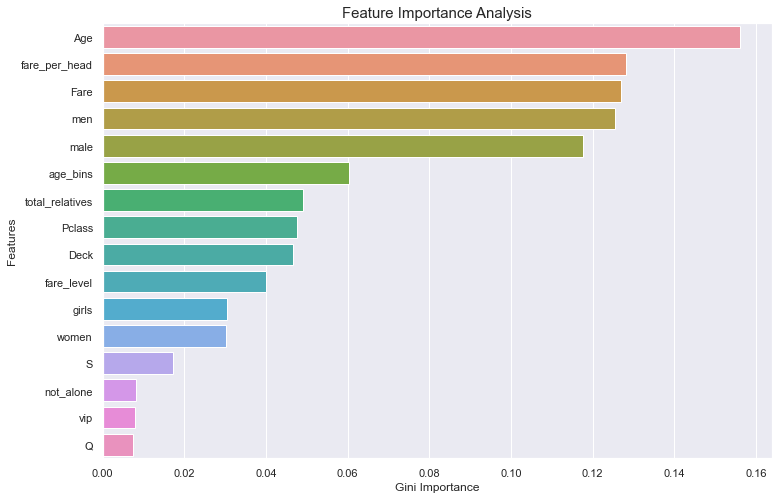

In [127]:
plt.figure(figsize=(12,8))
sns.barplot(y='Features',x='Gini Importance',data=feature_imp)
plt.title('Feature Importance Analysis',fontsize=15)
plt.show()

From above analysis, we can drop last 4 features namely 'S','vip','not_alone' and 'Q' as they are of lowest importance. 

## Model Building

In [128]:
top_features = features.drop([ 'S','vip','not_alone','Q'],axis=1)
top_features.columns

Index(['Pclass', 'Age', 'Fare', 'Deck', 'male', 'total_relatives', 'age_bins',
       'girls', 'men', 'women', 'fare_per_head', 'fare_level'],
      dtype='object')

In [129]:
X = top_features.to_numpy()
y = train_df[['Survived']].to_numpy()
print('Features shape = ',X.shape)
print('Target shape = ',y.shape)

Features shape =  (891, 12)
Target shape =  (891, 1)


 Taking a stratified sampling so the model could be tested on data having same proportions as observed in dataset.

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=1,test_size=0.2)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((712, 12), (712, 1), (179, 12), (179, 1))

In [131]:
np.unique(y_train,return_counts=True)

(array([0, 1], dtype=int64), array([439, 273], dtype=int64))

### 1. Random Forest Classifier

In [132]:
rf_classifier = RandomForestClassifier()
param_dic = {'n_estimators':[300,400,500],
            'max_depth':[5,6,7,9],
            'min_samples_split':[8,10,12,15,20]}
grid_search = GridSearchCV(estimator=rf_classifier,param_grid=param_dic,cv=10,n_jobs=-1,scoring='f1')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 9],
                         'min_samples_split': [8, 10, 12, 15, 20],
                         'n_estimators': [300, 400, 500]},
             scoring='f1')

In [133]:
grid_search.best_params_

{'max_depth': 6, 'min_samples_split': 15, 'n_estimators': 500}

In [134]:
rf_classifier = RandomForestClassifier(n_estimators=500,max_depth=5,min_samples_split=15)
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, min_samples_split=15, n_estimators=500)

In [135]:
rf_preds = rf_classifier.predict(X_test)

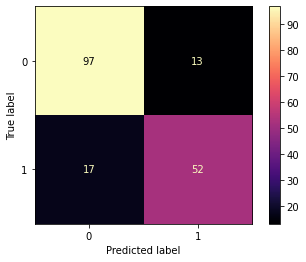

In [136]:
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test,rf_preds,cmap='magma')

In [137]:
print(classification_report(y_test,rf_preds))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       110
           1       0.80      0.75      0.78        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



### 2. Naive Bayes

In [138]:
nb_classifier = ComplementNB()
nb_classifier.fit(X_train,y_train)

ComplementNB()

In [139]:
nb_preds = nb_classifier.predict(X_test)

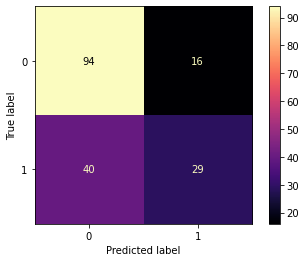

In [140]:
ConfusionMatrixDisplay.from_predictions(y_test,nb_preds,cmap='magma')

In [141]:
print(classification_report(y_test,nb_preds))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77       110
           1       0.64      0.42      0.51        69

    accuracy                           0.69       179
   macro avg       0.67      0.64      0.64       179
weighted avg       0.68      0.69      0.67       179



### 3. SVM classifier

In [142]:
svm_classifier = SVC()
svm_classifier.fit(X_train,y_train)

SVC()

In [143]:
svm_preds = svm_classifier.predict(X_test)

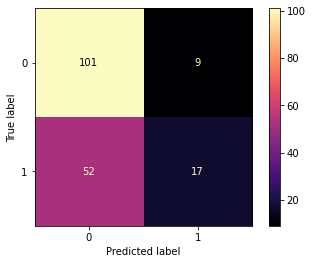

In [144]:
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test,svm_preds,cmap='magma')

In [145]:
print(classification_report(y_test,svm_preds))

              precision    recall  f1-score   support

           0       0.66      0.92      0.77       110
           1       0.65      0.25      0.36        69

    accuracy                           0.66       179
   macro avg       0.66      0.58      0.56       179
weighted avg       0.66      0.66      0.61       179



### 4. Decison Tree Classifier

In [146]:
dt_classifier = DecisionTreeClassifier(max_depth=5, min_samples_split=15)
dt_classifier.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=15)

In [147]:
dt_preds = dt_classifier.predict(X_test)

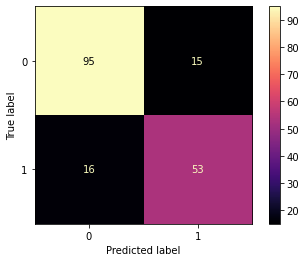

In [148]:
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test,dt_preds,cmap='magma')

In [149]:
print(classification_report(y_test,svm_preds))

              precision    recall  f1-score   support

           0       0.66      0.92      0.77       110
           1       0.65      0.25      0.36        69

    accuracy                           0.66       179
   macro avg       0.66      0.58      0.56       179
weighted avg       0.66      0.66      0.61       179



### 5. XGB Classifier

In [150]:
xgb_classifier = XGBClassifier(booster='gbtree',n_estimators=500,
                          max_depth=5,min_child_weight=15,
                         reg_alpha=1e-05,learning_rate=0.01)

In [151]:
xgb_classifier.fit(X_train,y_train)

[08:14:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=15, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [152]:
xgb_preds = xgb_classifier.predict(X_test)

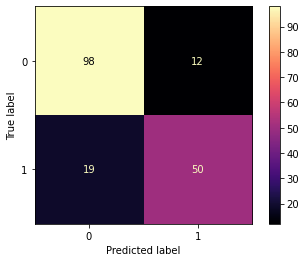

In [153]:
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test,xgb_preds,cmap='magma')

In [154]:
print(classification_report(y_test,xgb_preds))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



**Conclusion** : Out of all classifier Random Forest Classifier has better f1-score. 

### ROC curve for Random Forest Model

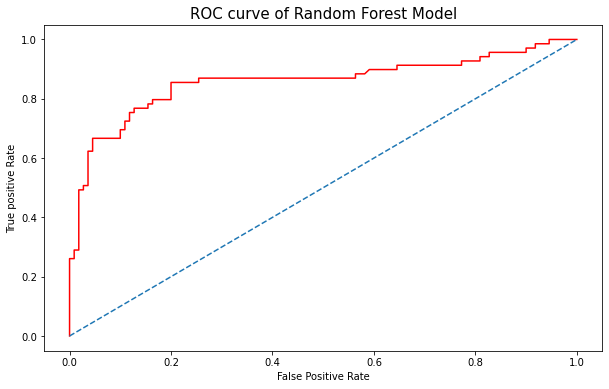

In [155]:
rf_probs = rf_classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test,rf_probs[:,1])
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,linestyle='-', color='red')
plt.plot([0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('ROC curve of Random Forest Model',fontsize=15)
plt.show()

#### AUC score of Random Forest Model

In [156]:
print('AUC score of the model = ',roc_auc_score(y_test,rf_probs[:,1]))

AUC score of the model =  0.8572463768115941


### Reshaping test data for predictions

In [157]:
test_df.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,U
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,U
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,U


In [158]:
# Features used in model training.
top_features.columns

Index(['Pclass', 'Age', 'Fare', 'Deck', 'male', 'total_relatives', 'age_bins',
       'girls', 'men', 'women', 'fare_per_head', 'fare_level'],
      dtype='object')

In [ ]:
sex_dummy_test = pd.get_dummies(test_df['Sex'],drop_first=True)
test_df = pd.concat([test_df,sex_dummy_test],axis=1).drop('Sex',axis=1)
test_df['total_relatives'] = test_df['SibSp'] + test_df['Parch']
test_df.drop(['SibSp','Parch'],axis=1,inplace=True)
test_df['age_bins'] = pd.cut(test_df['Age'],bins=age_bins,include_lowest=True)
test_df['age_bins'] = age_encoder.transform(test_df[['age_bins']])
test_df.head()

In [ ]:
test_df['title'] = test_df['Name'].apply(find_title)
test_df['title'].unique()

In [ ]:
test_df.query('title == ""')

In [ ]:
test_df.iloc[414,-1] = 'Mrs.'

In [ ]:
test_df.drop('Name',axis=1,inplace=True)

In [ ]:
test_df['title'] = test_df['title'].apply(title_encoding)
title_dummy = pd.get_dummies(test_df['title'],drop_first=True)
test_df = pd.concat([test_df,title_dummy],axis=1).drop('title',axis=1)
test_df['fare_per_head'] = np.round(test_df['Fare'] / (test_df['total_relatives']+1),2)
test_df['fare_level'] = pd.cut(test_df['Fare'],bins=fare_bins,include_lowest=True)
test_df['fare_level'] = fare_encoder.transform(test_df[['fare_level']])
test_df['Deck'] = deck_encoder.transform(test_df[['Deck']])
test_df.head(3)

In [ ]:
test_df.drop(['vip','Embarked'],axis=1,inplace=True)

In [ ]:
test_df.head()

In [ ]:
top_features.columns == test_df.columns

Now, the data is in the same format as top_features on which model was trained.

### Prediction on test data.

In [ ]:
model_inputs = test_df.to_numpy()
model_inputs.shape

In [ ]:
test_pred= rf_classifier.predict(model_inputs)

In [ ]:
pd.Series(test_pred).value_counts()

In [ ]:
test_with_pred.drop('Survived',axis=1,inplace=True)

In [ ]:
test_with_pred = pd.concat([test,pd.Series(test_pred,name='Survived')],axis=1)
test_with_pred.head()

In [ ]:
test_with_pred.groupby(['Survived','Sex'])['Survived'].count()

In [ ]:
train.groupby(['Survived','Sex'])['Survived'].count()

The predicted survival seems to be fair as compared to train data.

In [ ]:
# Exporting csv for submission.
df = test_with_pred[['PassengerId','Survived']]
df.to_csv('Submisssion.csv',index=False)